In [1]:
from __future__ import division
from __future__ import print_function

import time
import argparse
import numpy as np

import torch
import torch.optim as optim

from utils import load_data,normalize,toy_data,norm_embed,nmi_score

import networkx as nx
import matplotlib.pyplot as plt 

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from layers import GraphConvolution, InnerProduct
from utils import norm_embed
import torch

In [3]:
class GNN(nn.Module):
    
    def __init__(self, batch_size, nfeat, nhid, ndim):
        super(GNN, self).__init__()

        self.gc1 = GraphConvolution(batch_size, nfeat, nhid)
        self.embeddings = GraphConvolution(batch_size, nhid, 2*ndim)
        self.reconstructions = InnerProduct(2*ndim)

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = self.embeddings(x, adj)
        x = norm_embed(x)
        x = self.reconstructions(x)
        p = torch.sigmoid(x)
        return p
    

In [4]:
np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False,precision=8)

In [5]:
# Training settings
parser = argparse.ArgumentParser()
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='Disables CUDA training.')
parser.add_argument('--fastmode', action='store_true', default=False,
                    help='Validate during training pass.')
parser.add_argument('--seed', type=int, default=426, help='Random seed.')
parser.add_argument('--epochs', type=int, default=20000,
                    help='Number of epochs to train.')
parser.add_argument('--lr', type=float, default=0.1,
                    help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=10e-8,
                    help='Weight decay (L2 loss on parameters).')
parser.add_argument('--hidden', type=int, default=16,
                    help='Number of hidden units.')
parser.add_argument('--ndim', type=int, default=2,
                    help='Embeddings dimension.')

args = parser.parse_args(args=[])
args.cuda = not args.no_cuda and torch.cuda.is_available()

In [6]:
# Karate Club Binary Network
G = nx.karate_club_graph()
adj = nx.to_numpy_matrix(G)
adj = torch.FloatTensor(adj)
adj = torch.unsqueeze(adj,0)

In [7]:
def GraphNeuralNet(adj,dim):
    
    # Set the random seed
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed)
        
    args.ndim = dim
    
    adj_norm = normalize(adj)

    adj = torch.FloatTensor(np.array(adj))
    adj_norm = torch.FloatTensor(np.array(adj_norm))

    # Model and optimizer
    model = GNN(batch_size=adj_norm.shape[0],
                nfeat=adj_norm.shape[1],
                nhid=args.hidden,
                ndim=args.ndim)

    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    model.embeddings.register_forward_hook(get_activation('embeddings'))


    optimizer = optim.Adam(model.parameters(),
                           lr=args.lr, weight_decay=args.weight_decay)



    features = torch.FloatTensor(torch.eye(adj.shape[1]))
    features = features.reshape((1,adj.shape[1],adj.shape[1]))
    features = features.repeat(adj.shape[0], 1, 1)

    if args.cuda:
        model.cuda()
        features = features.cuda()
        adj = adj.cuda()
        adj_norm = adj_norm.cuda()


    # Train model
    t_total = time.time()
    A2norm = (adj_norm ** 2).mean()
    #A2norm = (adj_norm ** 2).view(adj_norm.shape[0],-1).mean(axis=1)
    
    losses = []
    
    for epoch in range(args.epochs):

        t = time.time()
        model.train()
        optimizer.zero_grad()
        p = model(features, adj_norm)

        # loss function
        criterion = torch.nn.BCELoss()

        loss = criterion(torch.flatten(p), torch.flatten(adj)) #/ A2norm
        loss.backward()
        optimizer.step()

        if epoch == 0:
            best_loss = loss
        else:
            if loss < best_loss:
                best_loss = loss
            elif loss == best_loss:
                best_loss = loss

        if epoch % 1000 == 0:
            print('Epoch: {:04d}'.format(epoch + 1),
                  'loss: {:.8f}'.format(best_loss.item()),
                  'time: {:.4f}s'.format(time.time() - t))
            
        losses.append(loss)

    print("Optimization Finished!")
    print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
    
    return p,losses


In [8]:
dim=1
p,losses = GraphNeuralNet(adj=adj,dim=dim)

Epoch: 0001 loss: 0.69314629 time: 0.0000s
Epoch: 1001 loss: 0.29742247 time: 0.0000s
Epoch: 2001 loss: 0.29742214 time: 0.0000s
Epoch: 3001 loss: 0.29742214 time: 0.0000s
Epoch: 4001 loss: 0.29406449 time: 0.0000s
Epoch: 5001 loss: 0.29394093 time: 0.0000s
Epoch: 6001 loss: 0.28858045 time: 0.0000s
Epoch: 7001 loss: 0.28702611 time: 0.0000s
Epoch: 8001 loss: 0.28699586 time: 0.0000s
Epoch: 9001 loss: 0.28545535 time: 0.0000s
Epoch: 10001 loss: 0.28515700 time: 0.0040s
Epoch: 11001 loss: 0.28513551 time: 0.0000s
Epoch: 12001 loss: 0.28513157 time: 0.0041s
Epoch: 13001 loss: 0.28018853 time: 0.0000s
Epoch: 14001 loss: 0.27968422 time: 0.0000s
Epoch: 15001 loss: 0.27831250 time: 0.0000s
Epoch: 16001 loss: 0.27760094 time: 0.0000s
Epoch: 17001 loss: 0.27731758 time: 0.0011s
Epoch: 18001 loss: 0.27716404 time: 0.0000s
Epoch: 19001 loss: 0.27707660 time: 0.0000s
Optimization Finished!
Total time elapsed: 13.8236s


NMI Score : 0.2755260826524358


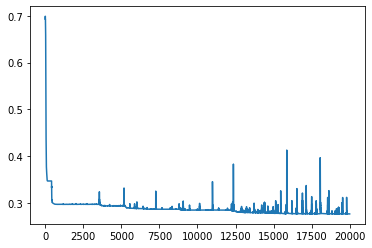

In [9]:
plt.plot(losses)
nmi = nmi_score(adj[0],p.reshape(adj.shape[1:]).detach())
print("NMI Score : {}".format(nmi))

In [10]:
dim=2
p,losses = GraphNeuralNet(adj=adj,dim=dim)

Epoch: 0001 loss: 0.69313908 time: 0.0000s
Epoch: 1001 loss: 0.18626995 time: 0.0080s
Epoch: 2001 loss: 0.18230140 time: 0.0080s
Epoch: 3001 loss: 0.18071719 time: 0.0000s
Epoch: 4001 loss: 0.17922910 time: 0.0000s
Epoch: 5001 loss: 0.17741436 time: 0.0000s
Epoch: 6001 loss: 0.17667812 time: 0.0000s
Epoch: 7001 loss: 0.17667812 time: 0.0000s
Epoch: 8001 loss: 0.17667812 time: 0.0000s
Epoch: 9001 loss: 0.17667812 time: 0.0000s
Epoch: 10001 loss: 0.17667812 time: 0.0000s
Epoch: 11001 loss: 0.17667812 time: 0.0000s
Epoch: 12001 loss: 0.17667812 time: 0.0000s
Epoch: 13001 loss: 0.17667812 time: 0.0000s
Epoch: 14001 loss: 0.17667812 time: 0.0000s
Epoch: 15001 loss: 0.17667812 time: 0.0000s
Epoch: 16001 loss: 0.17667812 time: 0.0000s
Epoch: 17001 loss: 0.17667812 time: 0.0000s
Epoch: 18001 loss: 0.17667812 time: 0.0040s
Epoch: 19001 loss: 0.17667812 time: 0.0000s
Optimization Finished!
Total time elapsed: 17.5987s


NMI Score : 0.6562984341134843


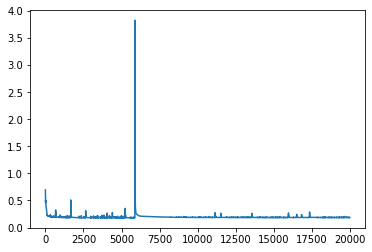

In [11]:
plt.plot(losses)
nmi = nmi_score(adj[0],p.reshape(adj.shape[1:]).detach())
print("NMI Score : {}".format(nmi))

In [12]:
dim=3
p,losses = GraphNeuralNet(adj=adj,dim=dim)

Epoch: 0001 loss: 0.69311911 time: 0.0000s
Epoch: 1001 loss: 0.12505601 time: 0.0000s
Epoch: 2001 loss: 0.11954801 time: 0.0000s
Epoch: 3001 loss: 0.11758263 time: 0.0010s
Epoch: 4001 loss: 0.11644974 time: 0.0010s
Epoch: 5001 loss: 0.11516818 time: 0.0010s
Epoch: 6001 loss: 0.11424655 time: 0.0000s
Epoch: 7001 loss: 0.11313070 time: 0.0010s
Epoch: 8001 loss: 0.11241331 time: 0.0010s
Epoch: 9001 loss: 0.11149502 time: 0.0010s
Epoch: 10001 loss: 0.11039422 time: 0.0010s
Epoch: 11001 loss: 0.10981151 time: 0.0010s
Epoch: 12001 loss: 0.10945521 time: 0.0000s
Epoch: 13001 loss: 0.10903215 time: 0.0000s
Epoch: 14001 loss: 0.10846125 time: 0.0000s
Epoch: 15001 loss: 0.10798503 time: 0.0040s
Epoch: 16001 loss: 0.10776261 time: 0.0030s
Epoch: 17001 loss: 0.10748108 time: 0.0030s
Epoch: 18001 loss: 0.10734694 time: 0.0000s
Epoch: 19001 loss: 0.10734694 time: 0.0000s
Optimization Finished!
Total time elapsed: 23.8016s


NMI Score : 0.930000157198609


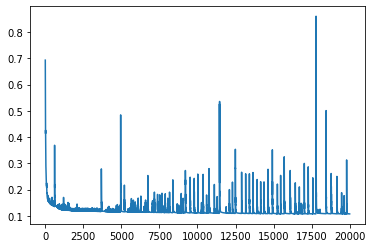

In [13]:
plt.plot(losses)
nmi = nmi_score(adj[0],p.reshape(adj.shape[1:]).detach())
print("NMI Score : {}".format(nmi))

In [14]:
dim=4
p,losses = GraphNeuralNet(adj=adj,dim=dim)

Epoch: 0001 loss: 0.69315106 time: 0.0000s
Epoch: 1001 loss: 0.07117777 time: 0.0030s
Epoch: 2001 loss: 0.05655992 time: 0.0000s
Epoch: 3001 loss: 0.04743750 time: 0.0000s
Epoch: 4001 loss: 0.04449499 time: 0.0000s
Epoch: 5001 loss: 0.04223744 time: 0.0040s
Epoch: 6001 loss: 0.04087482 time: 0.0000s
Epoch: 7001 loss: 0.03981902 time: 0.0040s
Epoch: 8001 loss: 0.03858813 time: 0.0040s
Epoch: 9001 loss: 0.03844355 time: 0.0000s
Epoch: 10001 loss: 0.03780691 time: 0.0040s
Epoch: 11001 loss: 0.03734947 time: 0.0040s
Epoch: 12001 loss: 0.03643118 time: 0.0000s
Epoch: 13001 loss: 0.03591245 time: 0.0000s
Epoch: 14001 loss: 0.03527333 time: 0.0040s
Epoch: 15001 loss: 0.03411976 time: 0.0000s
Epoch: 16001 loss: 0.03374118 time: 0.0000s
Epoch: 17001 loss: 0.03336966 time: 0.0000s
Epoch: 18001 loss: 0.03336966 time: 0.0000s
Epoch: 19001 loss: 0.03279232 time: 0.0000s
Optimization Finished!
Total time elapsed: 26.4085s


NMI Score : 0.8150419216347781


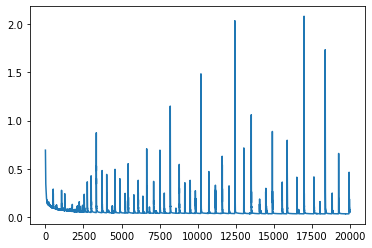

In [15]:
plt.plot(losses)
nmi = nmi_score(adj[0],p.reshape(adj.shape[1:]).detach())
print("NMI Score : {}".format(nmi))